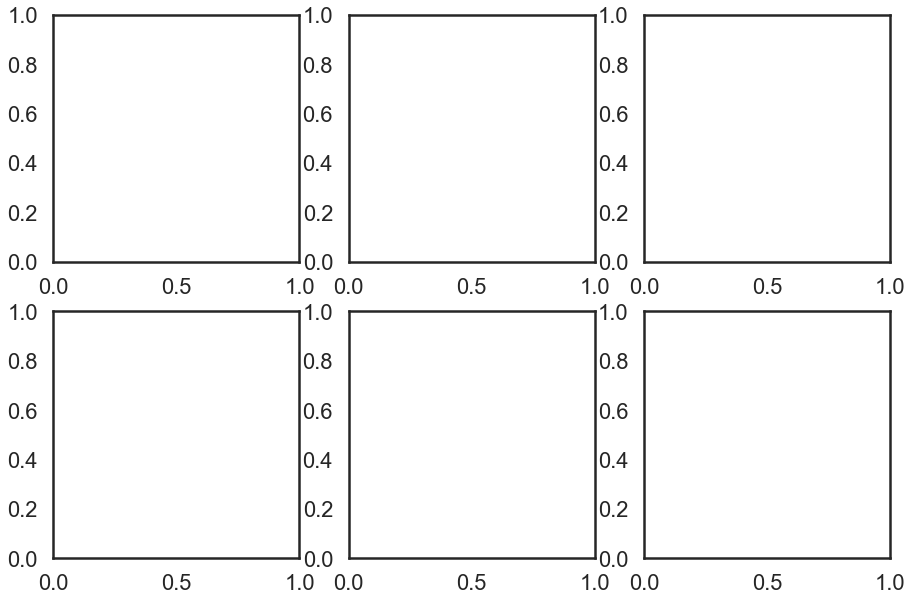

In [1]:
import numpy as np
import scipy.io as sio
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.sparse import csgraph
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import pandas
import seaborn as sns
from sklearn.cluster import KMeans

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

fig, axes = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(15)

In [ ]:
# [Vsort,Dsort] = eigsort(V, eigvals)
#
# Sorts a matrix eigenvectors and a array of eigenvalues in order
# of eigenvalue size, largest eigenvalue first and smallest eigenvalue
# last.
#
# Example usage:
# di, V = np.linarg.eig(L)
# Vnew, Dnew = eigsort(V, di)
#
# Tim Marks 2002

In [2]:
def eigsort(V, eigvals):

    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)

    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:, i] = V[:, index[i]]
    return Vsort, Dsort

In [73]:
filenames = ['winequality-white.csv','winequality-red.csv']
names = ["fixed acidity",
         "volatile acidity",
         "citric acid",
         "residual sugar",
         "chlorides",
         "free sulfur dioxide",
         "total sulfur dioxide",
         "density",
         "pH",
         "sulphates",
         "alcohol",
         "quality"]

d = []
for filename in filenames:
    df = pandas.read_csv(filename, names=names, sep=";")
    d.append(df)

data = pandas.concat(d, ignore_index=True)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [93]:
## Step 1/2: Compute affinity/similarity matrix, set diagonal entries to 0
## Set std to 40 bc 0.9 was wayyyy to small
def similarity_func(u, v):
    sigsq = 1600
    x = u - v
    d = - (x.dot(x.T)) / (2*sigsq)
    return np.exp(d)
dists = pdist(data, similarity_func)
W = pandas.DataFrame(squareform(dists), columns=list(range(0,data.shape[0])))

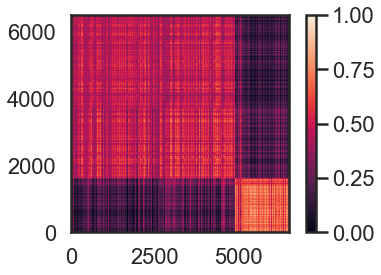

In [94]:
im = plt.imshow(W, extent=[0,data.shape[0],0,data.shape[0]])
plt.colorbar(im)

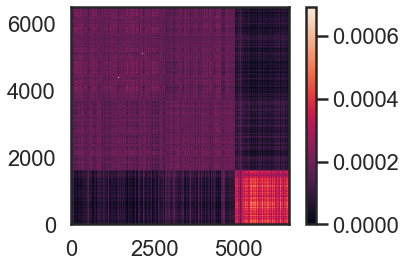

In [99]:
## Step 3: Computer normalized graph Laplacian
D = np.diag(np.sum(W.T, axis=0))
L = np.linalg.inv(np.sqrt(D)).dot(W).dot(np.linalg.inv(np.sqrt(D)))
vmax = np.amax(np.ndarray.max(L, axis=0))
vmin = np.amin(np.ndarray.min(L, axis=0))
im = plt.imshow(L, extent=[0, data.shape[0], 0, data.shape[0]])
plt.clim(vmin, vmax/250)
plt.colorbar(im)

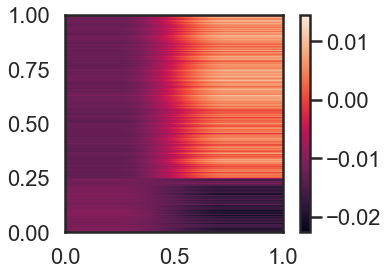

In [113]:
## Step 4: Compute top k eigenvectors
num_eigvec = 2
di, X = np.linalg.eig(L)
Xsort, Dsort = eigsort(X,di)
Xuse = Xsort[:, :num_eigvec]
im = plt.imshow(Xuse, extent=[0, 1, 0, 1])
plt.colorbar(im)

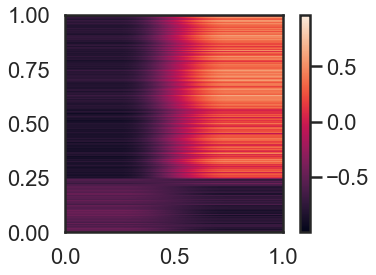

In [114]:
## Step 5: Compute Y by normalizing X
Xsq = np.multiply(Xuse, Xuse)
divmat = repmat(np.sqrt(np.sum(Xsq.T, axis=0)).reshape(-1,1), 1, 2)
Y = np.divide(Xuse, divmat)
im = plt.imshow(Y, extent=[0, 1, 0, 1])
plt.colorbar(im)

In [117]:
# Step 6: Run k-means on eigenvectors 
cluster_size = num_eigvec
kmeans = KMeans(n_clusters=cluster_size).fit(Y)
kk = kmeans.labels_

## Because our data has dimension higher than 2, we cannot visualize the vector clusters
print("K-means results of full-dimension data:")

clusters = []
for c_num in range(0, cluster_size):
    c = data.iloc[np.argwhere(kk == c_num).flatten()]
    clusters.append(c)
    print("Cluster {0} => size={1}, center={2}".format(c_num+1, c.shape[0], kmeans.cluster_centers_[c_num]))

K-means results of full-dimension data:
Cluster 1 => size=2494, center=[-0.64992075 -0.67582807]
Cluster 2 => size=4003, center=[-0.80483593  0.49654519]


[[-0.64992075 -0.80483593]
 [-0.67582807  0.49654519]]


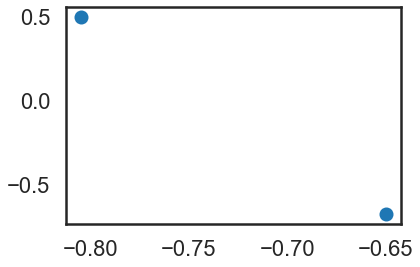

In [134]:
print(kmeans.cluster_centers_.T)
plt.scatter(x=kmeans.cluster_centers_.T[0], y=kmeans.cluster_centers_.T[1])
plt.scatter(x=kmeans)

In [ ]:
## Insert reg spectral clustering algorithm here and then compare cluster
## indices with cluster indicies from above to see the similarities